In [ ]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv
import os
from zipfile import ZipFile
from os import listdir
from os.path import isfile, join
import datetime
import time
import os
import numpy as np

# GPT2 with Fine Tuning

### Prepare data

In [2]:
data = np.load('data/forex/all_forex_data_ffill_test.csv.npy', allow_pickle=True)

In [3]:
directory = '../FX-1-Minute-Data/output'
folders = [x[0].split('\\')[-1] for x in os.walk(directory)][1:]
data = []
for folder in folders:
    zip_files = [f for f in listdir(f'{directory}/{folder}') if f.endswith('.zip') and '2021' not in f and 'USD' in f]

    dfs = pd.DataFrame()
    for file in zip_files:
        zip_file = ZipFile(f'{directory}/{folder}/{file}')
        df = pd.read_csv(zip_file.open(file[:-4]+'.csv'), names=['datetime', 'open', 'high', 'low', 'close', 'volume'], sep=';')
        df['datetime'] = df['datetime'].apply(lambda x: f'{x[:4]}-{x[4:6]}-{x[6:8]}T{x[9:11]}:{x[11:13]}:{x[13:15]}')
        df['day'] = df['datetime'].apply(lambda x: x.split('T')[0])
        df['minutes'] = df['datetime'].apply(lambda x: int(x.split('T')[1][:2])*60+int(x.split('T')[1][3:5]))
        print(len(df), len(dfs), len(data))
    
        df['file'] = file
        dfs = dfs.append(df)
    if dfs.shape[0] > 0:
        data.append(dfs)
        

121 0 0
62838 121 0
128952 62959 0
254957 191911 0
285701 446868 0
279026 732569 0
264136 1011595 0
280411 1275731 0
330754 1556142 0
351071 1886896 0
351500 2237967 0
355475 2589467 0
370878 2944942 0
370120 3315820 0
365190 3685940 0
371187 4051130 0
371005 4422317 0
368436 4793322 0
369457 5161758 0
371998 5531215 0
371875 5903213 0
38908 0 1
306992 38908 1
300099 345900 1
287891 645999 1
271410 933890 1
293648 1205300 1
296922 1498948 1
273114 1795870 1
307097 2068984 1
313629 2376081 1
319110 2689710 1
143167 0 2
230767 143167 2
213000 373934 2
316351 586934 2
328426 903285 2
315635 1231711 2
307176 1547346 2
299782 1854522 2
347355 2154304 2
355880 2501659 2
352320 2857539 2
358369 3209859 2
372161 3568228 2
370611 3940389 2
366477 4311000 2
372210 4677477 2
372679 5049687 2
371635 5422366 2
372607 5794001 2
372530 6166608 2
372335 6539138 2
132267 0 3
203038 132267 3
194701 335305 3
296418 530006 3
314580 826424 3
311286 1141004 3
308909 1452290 3
306750 1761199 3
332167 2067949

In [61]:
zf = ZipFile(f'data/firstratedata/crypto-active_1min_1nfzd.zip') 
data_files = zf.filelist
data = []
for file in data_files:
    if file.filename.startswith('USDC') or file.filename.startswith('USDT') or file.filename.startswith('BTC-EUR'):
        continue
    print(file.filename)
    df = pd.read_csv(zf.open(file), names=['datetime', 'Open', 'High', 'Low', 'close', 'Volume'])
#     df['datetime'] = df['datetime'].apply(lambda x: f'{x[:4]}-{x[4:6]}-{x[6:8]}T{x[9:11]}:{x[11:13]}:{x[13:15]}')
    df['day'] = df['datetime'].apply(lambda x: x.split(' ')[0])
#     df['minutes'] = df['datetime'].apply(lambda x: int(x.split(' ')[1][:2])*60+int(x.split(' ')[1][3:5]))
    print(len(df), len(data))

    df['file'] = file.filename
    data.append(df)
    

ADA_1min.txt
1178178 0
BAT_1min.txt
500581 1
BCH_1min.txt
1846720 2
BNT_1min.txt
1465424 3
BSV_1min.txt
1146548 4
BTC_1min.txt
3554967 5
BTG_1min.txt
1578585 6
CVC_1min.txt
280251 7
DAI_1min.txt
671067 8
DASH_1min.txt
1863195 9
DCR_1min.txt
162446 10
DOGE_1min.txt
1572341 11
EOS_1min.txt
2088508 12
ETC_1min.txt
2120606 13
ETH-BTC_1min.txt
2129947 14
ETH_1min.txt
2240474 15
FUN_1min.txt
133190 16
HT_1min.txt
34993 17
ICX_1min.txt
931845 18
IOST_1min.txt
806987 19
KNC_1min.txt
658569 20
LINK_1min.txt
1027417 21
LRC_1min.txt
410189 22
LSK_1min.txt
872413 23
LTC_1min.txt
2280868 24
MAID_1min.txt
1672742 25
MANA_1min.txt
380961 26
MKR_1min.txt
583169 27
NEO_1min.txt
1719494 28
OMG_1min.txt
1587057 29
ONT_1min.txt
950428 30
PAX_1min.txt
151895 31
QTUM_1min.txt
1022029 32
REP_1min.txt
1255607 33
SC_1min.txt
224033 34
SNT_1min.txt
117930 35
TRX_1min.txt
1605460 36
UST_1min.txt
864117 37
UTK_1min.txt
308697 38
VET_1min.txt
250213 39
WAVES_1min.txt
148002 40
XEM_1min.txt
1575953 41
XLM_1min.txt


In [62]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178178 entries, 0 to 1178177
Data columns (total 8 columns):
datetime    1178178 non-null object
Open        1178178 non-null float64
High        1178178 non-null float64
Low         1178178 non-null float64
close       1178178 non-null float64
Volume      1178178 non-null float64
day         1178178 non-null object
file        1178178 non-null object
dtypes: float64(5), object(3)
memory usage: 71.9+ MB


In [63]:
data[0]

,datetime,Open,High,Low,close,Volume,day,file
0,2018-03-01 00:18:00,0.32408,0.32422,0.32408,0.32422,600.000000,2018-03-01,<ZipInfo filename='ADA_1min.txt' compress_type...
1,2018-03-01 01:04:00,0.31669,0.31669,0.31669,0.31669,300.000000,2018-03-01,<ZipInfo filename='ADA_1min.txt' compress_type...
2,2018-03-01 01:07:00,0.31648,0.31648,0.31648,0.31648,400.000000,2018-03-01,<ZipInfo filename='ADA_1min.txt' compress_type...
3,2018-03-01 01:13:00,0.31639,0.31639,0.31639,0.31639,7000.000000,2018-03-01,<ZipInfo filename='ADA_1min.txt' compress_type...
4,2018-03-01 01:41:00,0.31540,0.31540,0.31500,0.31500,600.000000,2018-03-01,<ZipInfo filename='ADA_1min.txt' compress_type...
...,...,...,...,...,...,...,...,...
1178173,2021-07-16 23:54:00,1.17230,1.17290,1.17140,1.17170,21840.483461,2021-07-16,<ZipInfo filename='ADA_1min.txt' compress_type...
1178174,2021-07-16 23:55:00,1.17160,1.17380,1.17160,1.17350,28098.201525,2021-07-16,<ZipInfo filename='ADA_1min.txt' compress_type...
1178175,2021-07-16 23:56:00,1.17360,1.17400,1.17213,1.17390,62014.284493,2021-07-16,<ZipInfo filename='ADA_1min.txt' compress_type...
1178176,2021-07-16 23:57:00,1.17400,1.17480,1.17309,1.17330,20986.075034,2021-07-16,<ZipInfo filename='ADA_1min.txt' compress_type...


In [2]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [3]:
seq_len = 1024

In [73]:
market = 'crypto'
samples_tokenized = []
for i in range(len(data)):
    symbol = data[i]['file'].iloc[0].filename.split('_')[0] + 'USD'
    print(symbol)
    for idx, (day, group) in tqdm(enumerate(data[i].groupby('day')), total=len(data[i]['day'].unique())):
        prompt_txt = f"{market}_{symbol}_{day}\n;"
        prompt = tokenizer.encode(prompt_txt)
        tokens = tokenizer.encode(';'.join([f"{row['datetime'].split(' ')[1][:5]},{row['close']}" for idx, row in group.iterrows()]))
        
        token_len = (seq_len - len(prompt))
        iters = len(tokens) // token_len
#         leftover = len(tokens) % token_len
#         tokens = tokens[leftover//2:-leftover//2]
        for it in range(iters):
            sample = prompt + tokens[it*token_len:(it+1)*token_len]
            if len(sample) == 1024:
                samples_tokenized.append(prompt + tokens[it*token_len:(it+1)*token_len])

  0%|▏                                                                                                                                                                                                   | 1/1233 [00:00<03:02,  6.76it/s]

ADAUSD


  0%|▏                                                                                                                                                                                                   | 1/1285 [00:00<02:08, 10.00it/s]

BATUSD


  0%|                                                                                                                                                                                                            | 0/1320 [00:00<?, ?it/s]

BCHUSD


  0%|                                                                                                                                                                                                            | 0/1441 [00:00<?, ?it/s]

BNTUSD


  0%|                                                                                                                                                                                                             | 0/958 [00:00<?, ?it/s]

BSVUSD


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [02:27<00:00,  6.48it/s]


BTCUSD


  0%|                                                                                                                                                                                                            | 0/1353 [00:00<?, ?it/s]

BTGUSD


  1%|█▏                                                                                                                                                                                                  | 7/1135 [00:00<00:17, 65.42it/s]

CVCUSD


  0%|▍                                                                                                                                                                                                   | 3/1196 [00:00<00:41, 28.57it/s]

DAIUSD


  0%|                                                                                                                                                                                                            | 0/1537 [00:00<?, ?it/s]

DASHUSD


  4%|███████▍                                                                                                                                                                                           | 26/685 [00:00<00:02, 254.90it/s]

DCRUSD


  0%|                                                                                                                                                                                                            | 0/1506 [00:00<?, ?it/s]

DOGEUSD


  0%|                                                                                                                                                                                                            | 0/1476 [00:00<?, ?it/s]

EOSUSD


  0%|                                                                                                                                                                                                            | 0/1657 [00:00<?, ?it/s]

ETCUSD


  0%|                                                                                                                                                                                                            | 0/1500 [00:00<?, ?it/s]

ETH-BTCUSD


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:43<00:00,  5.29it/s]


ETHUSD


  1%|██▌                                                                                                                                                                                               | 19/1414 [00:00<00:07, 190.00it/s]

FUNUSD


  1%|██▋                                                                                                                                                                                                 | 10/737 [00:00<00:08, 85.47it/s]

HTUSD


  0%|▏                                                                                                                                                                                                   | 1/1347 [00:00<02:17,  9.80it/s]

ICXUSD


  0%|▏                                                                                                                                                                                                   | 1/1058 [00:00<01:57,  9.01it/s]

IOSTUSD


  1%|█▉                                                                                                                                                                                                 | 10/1006 [00:00<00:10, 98.04it/s]

KNCUSD


  0%|                                                                                                                                                                                                             | 0/746 [00:00<?, ?it/s]

LINKUSD


  1%|█▍                                                                                                                                                                                                   | 6/797 [00:00<00:15, 52.17it/s]

LRCUSD


  0%|                                                                                                                                                                                                            | 0/1261 [00:00<?, ?it/s]

LSKUSD


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1261/1261 [02:07<00:00,  9.86it/s]


LTCUSD


  0%|                                                                                                                                                                                                            | 0/1462 [00:00<?, ?it/s]

MAIDUSD


  1%|█▏                                                                                                                                                                                                  | 9/1437 [00:00<00:16, 86.54it/s]

MANAUSD


  2%|███▊                                                                                                                                                                                              | 22/1138 [00:00<00:05, 217.82it/s]

MKRUSD


  0%|                                                                                                                                                                                                            | 0/1408 [00:00<?, ?it/s]

NEOUSD


  0%|                                                                                                                                                                                                            | 0/1445 [00:00<?, ?it/s]

OMGUSD


  0%|                                                                                                                                                                                                            | 0/1129 [00:00<?, ?it/s]

ONTUSD


  2%|████▌                                                                                                                                                                                              | 18/769 [00:00<00:04, 178.22it/s]

PAXUSD


  0%|                                                                                                                                                                                                            | 0/1202 [00:00<?, ?it/s]

QTUMUSD


  0%|                                                                                                                                                                                                            | 0/1483 [00:00<?, ?it/s]

REPUSD


  1%|██▋                                                                                                                                                                                                  | 8/584 [00:00<00:07, 74.76it/s]

SCUSD


  0%|                                                                                                                                                                                                            | 0/1288 [00:00<?, ?it/s]

SNTUSD


  0%|                                                                                                                                                                                                            | 0/1378 [00:00<?, ?it/s]

TRXUSD


  0%|                                                                                                                                                                                                             | 0/958 [00:00<?, ?it/s]

USTUSD


  1%|█▊                                                                                                                                                                                                | 11/1181 [00:00<00:10, 108.91it/s]

UTKUSD


  0%|▉                                                                                                                                                                                                   | 5/1048 [00:00<00:22, 47.17it/s]

VETUSD


  1%|██▌                                                                                                                                                                                                  | 9/684 [00:00<00:08, 84.11it/s]

WAVESUSD


  0%|                                                                                                                                                                                                            | 0/1463 [00:00<?, ?it/s]

XEMUSD


  0%|                                                                                                                                                                                                            | 0/1233 [00:00<?, ?it/s]

XLMUSD


  0%|                                                                                                                                                                                                            | 0/1657 [00:00<?, ?it/s]

XMRUSD


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1657/1657 [04:38<00:00,  5.96it/s]


XRPUSD


  0%|                                                                                                                                                                                                            | 0/1474 [00:00<?, ?it/s]

XTZUSD


  0%|                                                                                                                                                                                                            | 0/1383 [00:00<?, ?it/s]

XVGUSD


  0%|                                                                                                                                                                                                            | 0/1657 [00:00<?, ?it/s]

ZECUSD


  0%|                                                                                                                                                                                                            | 0/1135 [00:00<?, ?it/s]

ZILUSD


  0%|                                                                                                                                                                                                            | 0/1414 [00:00<?, ?it/s]

ZRXUSD


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1414/1414 [04:45<00:00,  4.95it/s]


In [74]:
samples_tokenized = np.array(samples_tokenized)

In [75]:
samples_tokenized.shape

(514046, 1024)

In [76]:
np.save('all_crypto_samples', samples_tokenized)

In [ ]:
def write_to_file(writer, data):
    """
    writes data to tfrecord file
    """
    feature = {
        "text": _int64_feature(data)
    }
    tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(tf_example.SerializeToString())

In [ ]:
def split_list(l, n):
    # splits list/string into n size chunks
    return [l[i:i + n] for i in range(0, len(l), n)]

In [ ]:
def write_files(files, files_per, output_dir, out_name, start_no, write_remainder=True, process_no=None):
    # writes a list of files to .tfrecords
    if files == None:
        return
    chunks = split_list(files, files_per)

    if len(chunks[-1]) != files_per and not write_remainder:  # pop the last file if it's length != files per
        remainder = chunks.pop(-1)
    else:
        remainder = None  # assuming files = remainder from an old chunk here
        files_per = len(chunks[-1])

    for files in chunks:
        fp = f"{output_dir}/{out_name}_{start_no}"
        if process_no is not None:
            fp += f"_{process_no}"
        fp += f"_{files_per}"  # add number of files in tfrecord to end of fp
        fp += ".tfrecords"
        with tf.io.TFRecordWriter(fp) as writer:
            for f in files:
                write_to_file(writer, f)
        start_no += 1
    return start_no, remainder

In [ ]:
create_tfrecords(params, write_remainder=True, write_every_n_files=1, save_checkpoints=False,
                     resume_from_checkpoint=False, display_pbar=False):
    files_per = 100000
    _tfrecord_count, remainder = write_files(tokenized_files_array, files_per=files_per,
                                                         output_dir='records', out_name='forex',
                                                         start_no=0, process_no=None)

In [ ]:
def create_tfrecords_mp(files, args):
    files = split_list(files, len(files) // cpu_count())
    with Pool(processes=cpu_count()) as pool:
        pbar = tqdm(pool.imap(create_tfrecords, zip(files, repeat(args), range(len(files)))))
        meta = {"discarded": 0, "processed": 0, "successful": 0}
        for results in pbar:
            pbar.update()
            for k, v in results.items():
                meta[k] += v  # update metadata
        return meta

In [19]:
sum([len(samples_tokenized[i])==1024 for i in range(len(samples_tokenized))])/len(samples_tokenized)

1.0

In [21]:
max(max(samples_tokenized))

49541

In [4]:
samples_tokenized = np.load('all_crypto_samples.npy', allow_pickle=True)

### Prepare the dataset

In [5]:
class SongLyrics(Dataset):
    
    def __init__(self, data, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.lyrics = data
        
    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, item):
        return torch.tensor(self.lyrics[item]).long()

In [6]:
dataset = SongLyrics(samples_tokenized, gpt2_type="gpt2", max_length=seq_len)

In [7]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model), np.log(5), np.log(dataset.__len__()/get_n_params(model)), dataset.__len__()/get_n_params(model)

(124439808, 1.6094379124341003, -5.489264652483911, 0.0041308806905262984)

##### Prepare training

In [11]:
del model

In [100]:
torch.cuda.empty_cache()

In [8]:
def train(
    dataset, model, tokenizer, batch_size_loader=32, epochs=1, 
    lr=2.5e-5, warmup_steps=200,
    gpt2_type="gpt2", output_dir=".", output_prefix="attempt1",
    test_mode=False,save_model_on_epoch=True,
):
    try:
        device=torch.device("cuda")
        model = model.cuda()
        model.train()

        optimizer = AdamW(model.parameters(), lr=lr)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
        )

        batch_size = 512//batch_size_loader
        train_dataloader = DataLoader(dataset, batch_size=batch_size_loader, shuffle=True)
        loss=0
        accumulating_batch_count = 0
        input_tensor = None
        
        acc = []
        acc_sign = []
        mae = []

        for epoch in range(epochs):

            print(f"Training epoch {epoch}")
            print(loss)
            pbar = tqdm(enumerate(train_dataloader), total=train_dataloader.__len__())
            for idx, input_tensor in pbar:
                input_tensor = input_tensor.to(device)
                outputs = model(input_tensor, labels=input_tensor)
                loss = outputs[0]
                loss.backward()
                
#                 inp = input_tensor.cpu().detach().numpy()
#                 logits = outputs['logits'].argmax(axis=2).cpu().detach().numpy()

#                 acc.append((logits == inp).sum()/logits.size)
#                 acc_sign.append((np.sign(logits-len(clusters)//2) == np.sign(inp-len(clusters)//2)).sum()/logits.size)
#                 mae.append(mean_absolute_error(inp, logits)/len(clusters))

                if (accumulating_batch_count % batch_size) == 0:
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
                    model.zero_grad()

                accumulating_batch_count += 1
                input_tensor = None
#                 pbar.set_postfix(loss=loss.cpu().detach().numpy(), ACC=acc[-1], ACC_sign=acc_sign[-1], a_mae=mae[-1],
#                                  lr=scheduler.get_last_lr()[0])
            if save_model_on_epoch:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),
                )    
    except Exception as e:
        print(f'{str(e)}')
        try:
            del model
            del optimizer
            del scheduler
            del train_dataloader
            del loss
            del input_tensor
            del outputs
        except:
            pass
        
        torch.cuda.empty_cache()
        model = GPT2LMHeadModel.from_pretrained('gpt2')
    return model

### Actual Training

In [13]:
torch.cuda.empty_cache()

In [ ]:
#Train the model on the specific data we have
model = train(dataset, model, tokenizer, batch_size_loader=4)

  0%|                                                                                                                                                                                                          | 0/128512 [00:00<?, ?it/s]

Training epoch 0
0


 11%|████████████████████▋                                                                                                                                                                    | 14368/128512 [1:33:01<13:00:51,  2.44it/s]

In [ ]:
#### Save the model to a pkl or something so it can be reused later on
torch.save(model, 'model_crypto.pt')

In [18]:
import matplotlib.pyplot as plt

In [14]:
s = """forex:AUDUSD:2001-05-22
234;08:25,0.5235;08:27,0.5235;08:28,0.5237;08:30,0.5236;08:31,0.5236;08:32,0.5235;08:33,0.5235;08:34,0.5237;08:35,0.5237;08:36,0.5236;08:37,0.5238;08:38,0.5239;08:40,0.5238;08:41,0.5239;08:42,0.5238;08:44,0.524;08:46,0.5242;08:48,0.5241;08:51,0.5243;08:52,0.5243;08:53,0.5243;08:54,0.5242;08:55,0.5241;08:56,0.5241;08:57,0.5238;08:59,0.5237;09:00,0.5237;09:01,0.5239;09:02,0.5241;09:03,0.5241;09:04,0.524;09:06,0.524;09:07,0.5241;09:16,0.5239;09:17,0.5241;09:18,0.524;09:20,0.5242;09:21,0.5243;09:23,0.5241;09:24,0.5242;09:25,0.5243;09:26,0.5242;09:27,0.5241;09:28,0.5241;09:31,0.5234;09:32,0.5236;09:33,0.5232;09:34,0.5233;09:35,0.5232;09:36,0.5231;09:37,0.523;09:38,0.5233;09:40,0.5227;09:41,0.5227;09:42,0.5227;09:43,0.5226;09:45,0.5225;09:46,0.5225;09:49,0.5228;09:51,0.5229;09:53,0.5234;09:54,0.5237;09:55,0.5237;09:56,0.5235;09:57,0.5235;09:58,0.5236;09:59,0.5235;10:00,0.5235;10:01,0.5237;10:02,0.5237;10:03,0.5239;10:04,0.5239;10:06,0.5238;10:07,0.5237;10:08,0.5237;10:10,0.5238;10:11,0.5237;10:14,0.5238;10:17,0.5238;10:19,0.5235;10:20,0.5237;10:22,0.5236;10:23,0.5234;10:25,0.5236;10:28,0.5237;10:31,0.5236;10:33,0.5236;10:34,0.5237;10:35,0.5236;10:36,0.5236;10:38,0.5237;10:39,0.5237;10:41,0.5236;10:42,0.5237;10:47,0.5233;10:48,0.5234;10:49,0.5233;10:50,0.5231;10:52,0.5229;10:53,0.5231;10:55,0.5231;10:56,0.523;10:57,0.5231;11:00,0.5233;11:03,0.5235;11:04,0.5236;11:06,0.5237;11:07,0.5236;11:08,0.5237;11:10,0.5238;11:11,0.5239;11:17,0.5238;11:18,0.5236"""

In [239]:
s = tokenizer.decode(samples_tokenized[10083])
s

'crypto_ADAUSD_2021-05-26\n;,1.7328;16:36,1.7446;16:37,1.7433;16:38,1.7428;16:39,1.7428;16:40,1.7327;16:41,1.7359;16:42,1.7348;16:43,1.7327;16:44,1.7316;16:45,1.72617;16:46,1.726;16:47,1.7327;16:48,1.7273;16:49,1.7185;16:50,1.7184;16:51,1.7179;16:52,1.71833;16:53,1.7232;16:54,1.7313;16:55,1.732;16:56,1.7251;16:57,1.7188;16:58,1.7273;16:59,1.72148;17:00,1.702;17:01,1.6995;17:02,1.7011;17:03,1.7043;17:04,1.6986;17:05,1.6942;17:06,1.68593;17:07,1.6897;17:08,1.685;17:09,1.6865;17:10,1.6933;17:11,1.68625;17:12,1.692;17:13,1.6962;17:14,1.69908;17:15,1.7025;17:16,1.7096;17:17,1.7068;17:18,1.7128;17:19,1.7183;17:20,1.7217;17:21,1.7211;17:22,1.7225;17:23,1.7243;17:24,1.7248;17:25,1.719;17:26,1.7205;17:27,1.7206;17:28,1.7262;17:29,1.7333;17:30,1.735;17:31,1.7444;17:32,1.7484;17:33,1.7455;17:34,1.7469400000000002;17:35,1.7437;17:36,1.7428;17:37,1.7426700000000002;17:38,1.742;17:39,1.73935;17:40,1.73863;17:41,1.7363;17:42,1.7397;17:43,1.7397;17:44,1.7403;17:45,1.7367;17:46,1.7318;17:47,1.7294;17:4

In [207]:
a = np.array([ss.split(',') for ss in s.split('\n')[1].split(';')][2:-1])
a[:,0] = [int(aa.split(':')[0])*60+int(aa.split(':')[1]) for aa in a[:,0]]
a = a.astype(float)

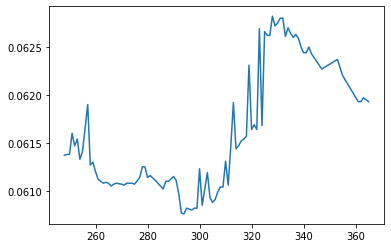

In [208]:
plt.plot(a[:,0], a[:,1])

In [92]:
del ss

In [209]:
skip_count = 203
s[-skip_count:]

'3,0.06242999999999999;05:47,0.062270000000000006;05:53,0.06237;05:55,0.0622;06:01,0.06192999999999999;06:02,0.06192999999999999;06:03,0.061970000000000004;06:04,0.06195;06:05,0.06192999999999999;06:06,0.'

In [210]:
ss = torch.tensor([tokenizer.encode(s[:-skip_count])]).long().cuda()

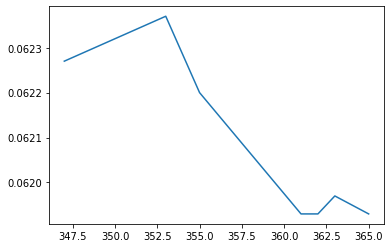

In [211]:
bb = np.array([ss.split(',') for ss in s[-skip_count:].split(';')][1:-1])
bb[:,0] = [int(aa.split(':')[0])*60+int(aa.split(':')[1]) for aa in bb[:,0]]
bb = bb.astype(float)
plt.plot(bb[:,0], bb[:,1])

In [212]:
s[-skip_count:]

'3,0.06242999999999999;05:47,0.062270000000000006;05:53,0.06237;05:55,0.0622;06:01,0.06192999999999999;06:02,0.06192999999999999;06:03,0.061970000000000004;06:04,0.06195;06:05,0.06192999999999999;06:06,0.'

In [216]:
b = model.generate(ss, repetition_penalty=0.5, top_k=100, max_length=1024, temperature=0.0, top_p=0.1, num_beams=3)[0][len(ss[0]):]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [217]:
tokenizer.decode(b)

',0.0625;05:43,0.0625;05:44,0.0625;05:45,0.0625;05:46,0.0625;05:47,0.0625;05:48,0.0625;05:49,0.0625;05:50,0.0625;05:51,0.0625;05:52,0.0625;05:53,0.0625;05'

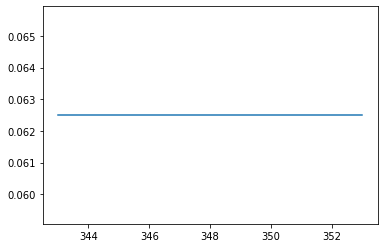

In [218]:
bb = np.array([ss.split(',') for ss in tokenizer.decode(b)[-len(ss[0]):].split(';')][1:-1])
bb[:,0] = [int(aa.split(':')[0])*60+int(aa.split(':')[1]) for aa in bb[:,0]]
bb = bb.astype(float)
plt.plot(bb[:,0], bb[:,1])

In [ ]:
#Rouge score
from rouge import Rouge
rouge=Rouge()

rouge.get_scores(test_set['Generated_lyrics'], test_set['True_end_lyrics'], avg=True, ignore_empty=True)

In [ ]:
!pip install rouge

In [ ]:
#Using BLEU score to compare the real sentences with the generated ones
import statistics
from nltk.translate.bleu_score import sentence_bleu

scores=[]

for i in range(len(test_set)):
  reference = test_set['True_end_lyrics'][i]
  candidate = test_set['Generated_lyrics'][i]
  scores.append(sentence_bleu(reference, candidate))

statistics.mean(scores)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4075527115657135

In [ ]:
#Finish the sentences when there is a point, remove after that
final=[]

for i in range(len(test_set)):
  to_remove = test_set['Generated_lyrics'][i].split('.')[-1]
  final.append(test_set['Generated_lyrics'][i].replace(to_remove,''))

test_set['Generated_lyrics'] = final
test_set.head()

,level_0,index,SName,Lyric,Artist,Genre,True_end_lyrics,Generated_lyrics
0,2946,3317,Do the Clam,(Words & music by Wayne - Weisman - Fuller). H...,Elvis Presley,Rock,Grab your barefoot baby by the hand. Turn and ...,
1,12130,13349,Elevation,"High, higher than the sun. You shoot me from a...",U2,Rock,in the sky. You make me feel like I can fly. S...,on earth.\nI start reading monographs about J...
2,596,640,Professional Torturer,Infatuation. Court well meant. 'Cause I'm the ...,Alanis Morissette,Rock,I renounce my name. Professional torturer. I d...,
3,3733,4116,I Am Yours,I am yours. However distant you may be. There ...,Eric Clapton,Rock,me. Each memory that has left its trace with m...,
4,11961,13175,Bombs Away,The general scratches his belly and thinks. Hi...,The Police,Rock,hard and sweet. A military man would love to m...,straight red hair.


In [ ]:
#Loop to keep only generated text and add it as a new column in the dataframe
my_generations=[]

for i in range(len(generated_lyrics)):
  a = test_set['Lyric'][i].split()[-30:] #Get the matching string we want (30 words)
  b = ' '.join(a)
  c = ' '.join(generated_lyrics[i]) #Get all that comes after the matching string
  my_generations.append(c.split(b)[-1])

test_set['Generated_lyrics'] = my_generations

In [ ]:
#Function to generate multiple sentences. Test data should be a dataframe
def text_generation(test_data):
  generated_lyrics = []
  for i in range(len(test_data)):
    x = gen_text(test_data['Lyric'][i], tokenizer, model)
    generated_lyrics.append(x)
  return generated_lyrics

generated_lyrics = text_generation(test_set)

In [ ]:
#Generate sequences
gen_text(df['Lyric'][0],tokenizer,model)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['I feel so unsure. As I take your hand and lead to the dance floor. As the music dies, something in your eyes. Calls to mind the silver screen. And all its sad good-byes. I\'m never gonna dance again. Guilty feet have got no rhythm. Though it\'s easy to pretend. I know you are not a fool. Should\'ve known better than to cheat a friend. And waste the chance that I\'ve been given. So I\'m never gonna dance again. The way I danced with you. Time can never mend. The careless whispers of a good friend. To the heart and mind. Ignorance is kind. There\'s no comfort in the truth. Pain is all you\'ll find. I\'m never gonna dance again. Guilty feet have got no rhythm. Though it\'s easy to pretend. I know you are not a fool. Should\'ve known better than to cheat a friend. And waste this chance that I\'ve been given. So I\'m never gonna dance again. The way I danced with you. Never without your love. Tonight the music seems so loud. I wish that we could lose this crowd. Maybe it\'s better this wa

In [ ]:
## Making a function that will generate text for us ##
def gen_text(prompt_text, tokenizer, model, n_seqs=1, max_length=374):
  # n_seqs is the number of sequences to generate
  # max_length is the maximum length of the sequence
  encoded_prompt = tokenizer.encode(prompt_text, add_special_tokens=False, return_tensors="pt")
  # We are encoding the text using the gpt tokenizer. The return tensors are of type "pt"
  # since we are using PyTorch, not tensorflow
  output_sequences = model.generate(
      input_ids=encoded_prompt,
      max_length=max_length+len(encoded_prompt), # The model has to generate something, 
      # so we add the length of the original sequence to max_length
      temperature=1.0,
      top_k=0,
      top_p=0.9,
      repetition_penalty=1.2, # To ensure that we dont get repeated phrases
      do_sample=True,
      num_return_sequences=n_seqs
  ) # We feed the encoded input into the model.
  ## Getting the output ##
  if len(output_sequences.shape) > 2:
    output_sequences.squeeze_() # the _ indicates that the operation will be done in-place
  generated_sequences = []
  for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
    generated_sequence = generated_sequence.tolist()
    text = tokenizer.decode(generated_sequence)
    total_sequence = (
        prompt_text + text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True, )) :]
    )
    generated_sequences.append(total_sequence)
  return generated_sequences

In [ ]:
tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
model = transformers.GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
import transformers
import torch

# GPT2 without any fine Tuning

In [ ]:
#Rouge score
from rouge import Rouge
rouge=Rouge()

rouge.get_scores(test_set['Generated_lyrics'], test_set['True_end_lyrics'], avg=True)

{'rouge-1': {'f': 0.33620873608456614,
  'p': 0.3805105543072668,
  'r': 0.33900000000000013},
 'rouge-2': {'f': 0.24573902727265526,
  'p': 0.280178576490597,
  'r': 0.252700228832952},
 'rouge-l': {'f': 0.3756182538370741,
  'p': 0.40754447860807824,
  'r': 0.39803790370276443}}

In [ ]:
#Using BLEU score to compare the real sentences with the generated ones
import statistics
from nltk.translate.bleu_score import sentence_bleu

scores=[]

for i in range(len(test_set)):
  reference = test_set['True_end_lyrics'][i]
  candidate = test_set['Generated_lyrics'][i]
  scores.append(sentence_bleu(reference, candidate))

statistics.mean(scores)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6848624352005677

### Analyze performance

In [ ]:
test_set['True_end_lyrics'][7]

"the. Woman without pride x 5. You don't see things like I do. You don't see things. Like I do."

In [ ]:
test_set['Generated_lyrics'][7]

" in that. Yes we've heard the great thing. I know what you've heard. You told me we've been promised so much."

In [ ]:
#Finish the sentences when there is a point, remove after that
final=[]

for i in range(len(test_set)):
  to_remove = test_set['Generated_lyrics'][i].split('.')[-1]
  final.append(test_set['Generated_lyrics'][i].replace(to_remove,''))

test_set['Generated_lyrics'] = final
test_set.head()

,index,SName,Lyric,Artist,Genre,True_end_lyrics,Generated_lyrics
0,2834,Don't Bring Me Down,"Hm hm hm. Hm hm hm. I'm on my own, nowhere to ...",David Bowie,Rock,me down. Until then I'll settle down. Say I'll...,me down. I want to see your face. I want to s...
1,6725,Flight,I've lost my balance. I fell from the trapeze....,Lifehouse,Rock,more falling). (No more striving). Only flying...,more falling). No more striving. No more hear...
2,7233,Black And Gold,If the fish swam out of the ocean. and grew le...,Lulu Santos,Rock,matter. 'cause if you're not really here. then...,magic words. 'cause if you're not real here. ...
3,2525,Hear My Train A Comin,"""YEAH, I SEE WE GOT A FEW FRIENDS LAYIN' ROUND...",Cássia Eller,Rock,YOU VERY MUCH THANK YOU VERY MUCH. THANX A LOT...,"S TO YOU. YES, YES, YES. YES. YES, YES."
4,1778,The Hills Of Mexico,'Twas in the town of griffin. In the year of s...,Bob Dylan,Rock,the cattle run. I tread towards the hiding pla...,"a horrid start. Struck my wagon, but couldn't..."


In [ ]:
#Loop to keep only generated text and add it as a new column in the dataframe
my_generations=[]

for i in range(len(generated_lyrics)):
  a = test_set['Lyric'][i].split()[-30:] #Get the matching string we want (30 words)
  b = ' '.join(a)
  c = ' '.join(generated_lyrics[i]) #Get all that comes after the matching string
  my_generations.append(c.split(b)[-1])

test_set['Generated_lyrics'] = my_generations

In [ ]:
generated_lyrics = text_generation(test_set)

In [ ]:
#Function to generate multiple sentences. Test data should be a dataframe
def text_generation(test_data):
  generated_lyrics = []
  for i in range(len(test_data)):
    x = generate(model.to('cpu'), tokenizer, test_data['Lyric'][i], entry_count=1)
    generated_lyrics.append(x)
  return generated_lyrics

In [ ]:
def generate(
    model,
    tokenizer,
    prompt,
    entry_count=10,
    entry_length=30, #maximum number of words
    top_p=0.8,
    temperature=1.,
):

    model.eval()

    generated_num = 0
    generated_list = []

    filter_value = -float("Inf")

    with torch.no_grad():

        for entry_idx in trange(entry_count):

            entry_finished = False

            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

            for i in range(entry_length):
                outputs = model(generated, labels=generated)
                loss, logits = outputs[:2]
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value

                next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token), dim=1)

                if next_token in tokenizer.encode("<|endoftext|>"):
                    entry_finished = True

                if entry_finished:

                    generated_num = generated_num + 1

                    output_list = list(generated.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)
                    generated_list.append(output_text)
                    break
            
            if not entry_finished:
              output_list = list(generated.squeeze().numpy())
              output_text = f"{tokenizer.decode(output_list)}<|endoftext|>" 
              generated_list.append(output_text)
                
    return generated_list

In [ ]:
#Load the model to use it
model = torch.load('/content/drive/MyDrive/Google colabs/model.pt')